# Duch soils

The properties of Dutch soils have been published by

Heinen M., G.Bakker and J.H.M.Wösten (2020) Waterretentie- en doorlatendheidskarakteristieken van boven- en ondergronden in Nederland: de Staringreeks; Update 2018. Wageningen, Wageningen Environmental Research, Rapport 2978, 78 blz.; 6 fig.; 4 tab.; 22 ref. ISSN 1566-7197.

The tables with the soil data are imported and allow compuation of suction, moisture and hydraulic conductivity relations for the most important Dutch soils, the so-called Staringreeks. The Staring Series defines 18 upper soils and 18 lower soils.

@TO Aug. 2026

In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle
import etc

sys.path.insert(0, os.getcwd())  # is line in .vscode/settings.json {"jupyter.notebookFileRoot": "${workspaceFolder}"}
from src import dutch_soils as ds

print(os.getcwd())

/Users/Theo/GRWMODELS/python/tools/Stromingen/Munsflow_H2O_1995


In [2]:
root = os.getcwd()
expected = "Munsflow_H2O_1995"
if not root.endswith(expected):
    raise RuntimeError(f"Unexpected project root: {root}")
dirs = etc.Dirs(root)

# Dutch soil properties

The properties of the Staringreeks, the series of Dutch soils, are read into a pandas DataFrame and stored as class attribute data in the Soil class, which is instantatied as with the class method load_soils(wbook). The paramters are the Van Genughten parameters so that moisture, suction and conductivities for each soil can be computed from them.

In [3]:
wbook = os.path.join(dirs.data, 'VG_soilprops.xlsx')
ds.Soil.load_soils(wbook) # load once
ds.Soil.pretty_data()
sand_b = ds.Soil("O01")
sand_o = ds.Soil("B01")

     Hoofdsoort  theta_r  theta_s   alpha      n  lambda      Ks                                     Omschrijving                 Leem   Lutum      os       M50   N1  N2
code                                                                                                                                                                     
B01        Zand     0.02    0.427  0.0217  1.735   0.981   31.23           leemarm, zeer fijn tot matig fijn zand                 0-10     NaN    0-15   105-210   32   7
B02        Zand     0.02    0.434  0.0216  1.349   7.202   83.24        zwak lemig, zeer fijn tot matig fijn zand                10-18     NaN    0-15   105-210   27  11
B03        Zand     0.02    0.443  0.0150  1.505   0.139   19.08       sterk lemig, zeer fijn tot matig fijn zand                18-33     NaN    0-15   105-210   14   4
B04        Zand     0.02    0.462  0.0149  1.397   0.295   34.88  zeer sterk lemig, zeer fijn tot matig fijn zand                33-50     NaN    0-15

### Showing the $\psi(\theta)$ relation for all soils, each with its field capacity and wilting point.

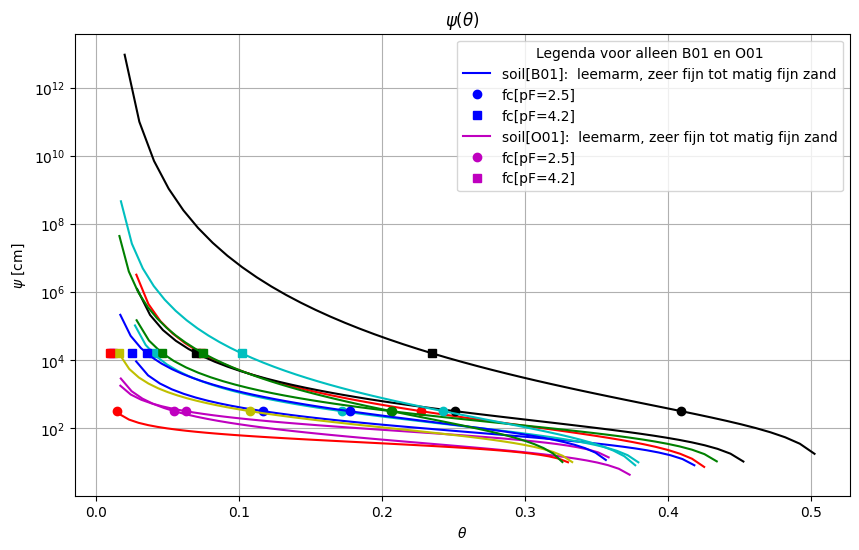

In [4]:
# %% psi(theta)
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=r"$\psi(\theta)$", xlabel=r'$\theta$', ylabel=r'$\psi$ [cm]')
ax.set_yscale('log')
ax.grid(True)

clrs = cycle("brgkmcy")
for code in ds.Soil.data.index:
    clr = next(clrs)
    soil = ds.Soil(code)
    if soil.props['Hoofdsoort'] != 'Zand':
        continue
    theta = np.linspace(soil.props['theta_r'], soil.props['theta_s'])[1:-1]
    label=f"soil[{code}]:  {soil.props['Omschrijving']}" if code.endswith('01') else ""
    ax.plot(theta, soil.psi_fr_theta(theta), color=clr, label=label)
    
    pF_fc, pF_wp = 2.5, 4.2
    lbl1 = f"fc[pF={pF_fc}]" if code.endswith('01') else ""
    lbl2 = f"fc[pF={pF_wp}]" if code.endswith('01') else ""
    ax.plot(soil.theta_fc(pF=pF_fc), 10 ** pF_fc, 'o', color=clr, label=lbl1)
    ax.plot(soil.theta_wp(pF=pF_wp), 10 ** pF_wp, 's', color=clr, label=lbl2)
ax.legend(title="Legenda voor alleen B01 en O01")

### Verifying $\psi(\theta)$ with $\theta(\psi)$

The most essential relation for unsaturated conditions is that of the suction head $\psi$ versus moisture content $\theta$ and the other way around.

Below function $\psi(\theta)$ is shown and the other way around by using $\psi(\theta(\psi))$

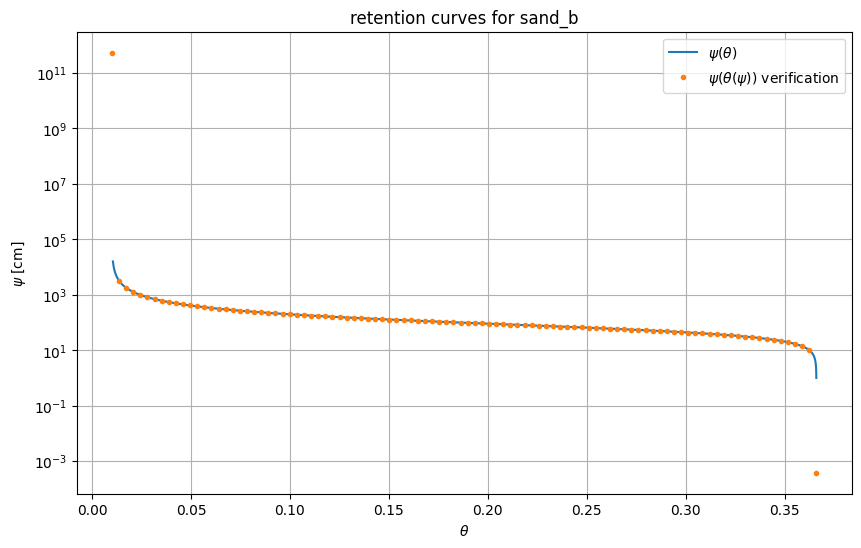

In [20]:
# %% psi(theta)
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title="retention curves for sand_b", xlabel=r'$\theta$', ylabel=r'$\psi$ [cm]')
ax.set_yscale('log')
ax.grid(which='both')

theta = np.linspace(sand_b.props['theta_r'], sand_b.props['theta_s'], 100)
psi = np.logspace(0, 4.2, 100)

ax.plot(sand_b.theta_fr_psi(psi), psi, label=r"$\psi(\theta)$")
ax.plot(theta, sand_b.psi_fr_theta(theta), '.', label=r"$\psi(\theta(\psi))$ verification")
ax.legend()

### $K$ versus $\theta$

Below the hydraulic conductivity vs $\theta$ is shown for all Dutch soils.

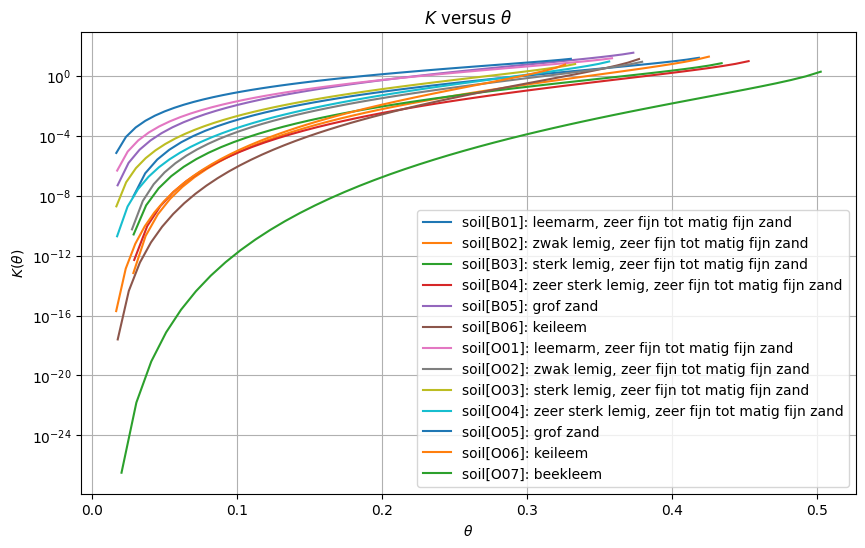

In [6]:
# %% K(theta)
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=r"$K$ versus $\theta$", xlabel=r'$\theta$', ylabel=r'$K(\theta)$')
ax.set_yscale('log')
ax.grid(True)

for code in ds.Soil.data.index:
    soil = ds.Soil(code)
    if soil.props['Hoofdsoort'].lower() != 'zand':
        continue
    theta = np.linspace(soil.props['theta_r'], soil.props['theta_s'])[1:-1]
    ax.plot(theta, soil.K(theta), label=f"soil[{code}]: {soil.props['Omschrijving']}")
ax.legend()

### $dK/d\theta$

$ dK/d\theta$ is important for flow through the percolation zone as it equals the velocity of the kinematic wave. To verify the analytic formula, we here compare it with the numerically computed derivative.

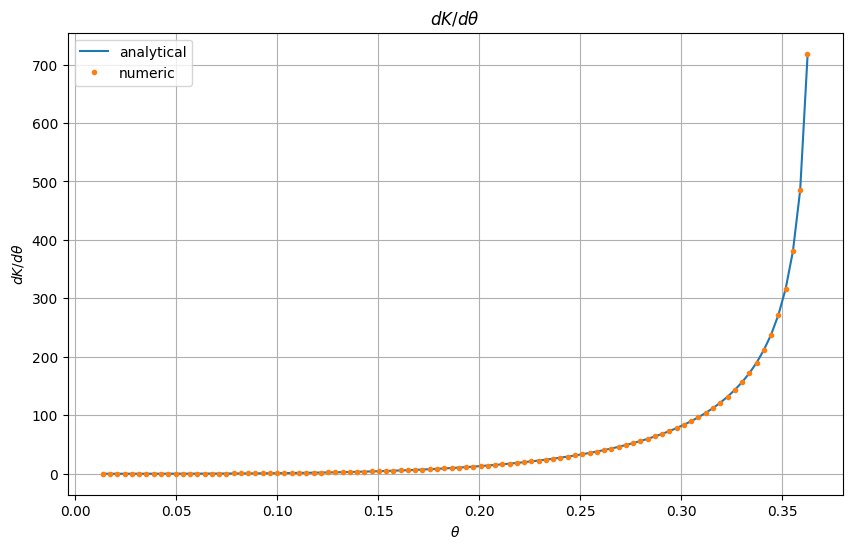

In [15]:
# %% dK(theta)/dtheta
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=r"$dK/d\theta$", xlabel=r'$\theta$', ylabel=r'$dK/d\theta$')
ax.set_yscale('log')
ax.set_yscale('linear')
ax.grid(True)

theta = np.linspace(sand_b.props['theta_r'], sand_b.props['theta_s'], 100)[1:-1]

d = 1e-3
dkdtheta_num = (sand_b.K(theta + d) - sand_b.K(theta - d)) / (2 * d)

ax.plot(theta, sand_b.dK_dtheta(theta), label="analytical")
ax.plot(theta, dkdtheta_num, '.', label="numeric")
ax.legend()

### Field capacity and wilting point (thetas)

Field capacity and wilting point (both as moisture values) are important for plants. Their difference is the available amount of water for plants. Below the field capacity and wilting point are shown for all Dutch soils.

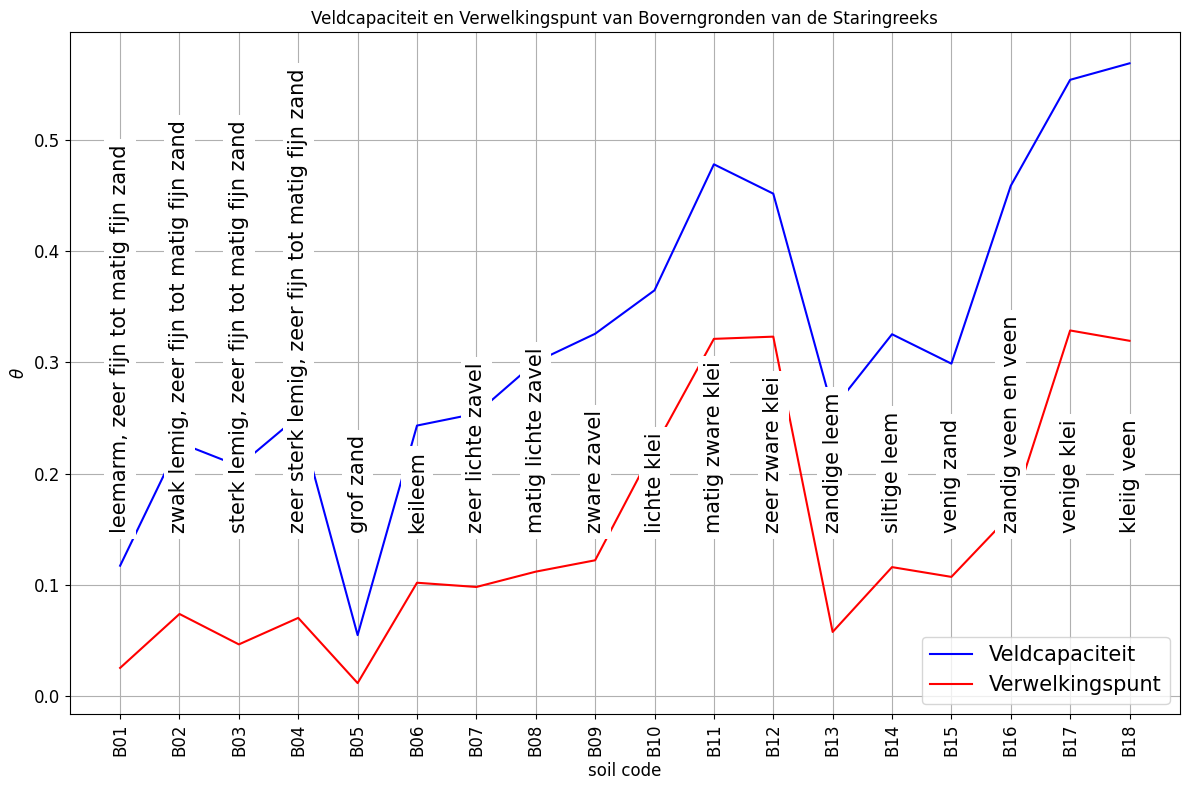

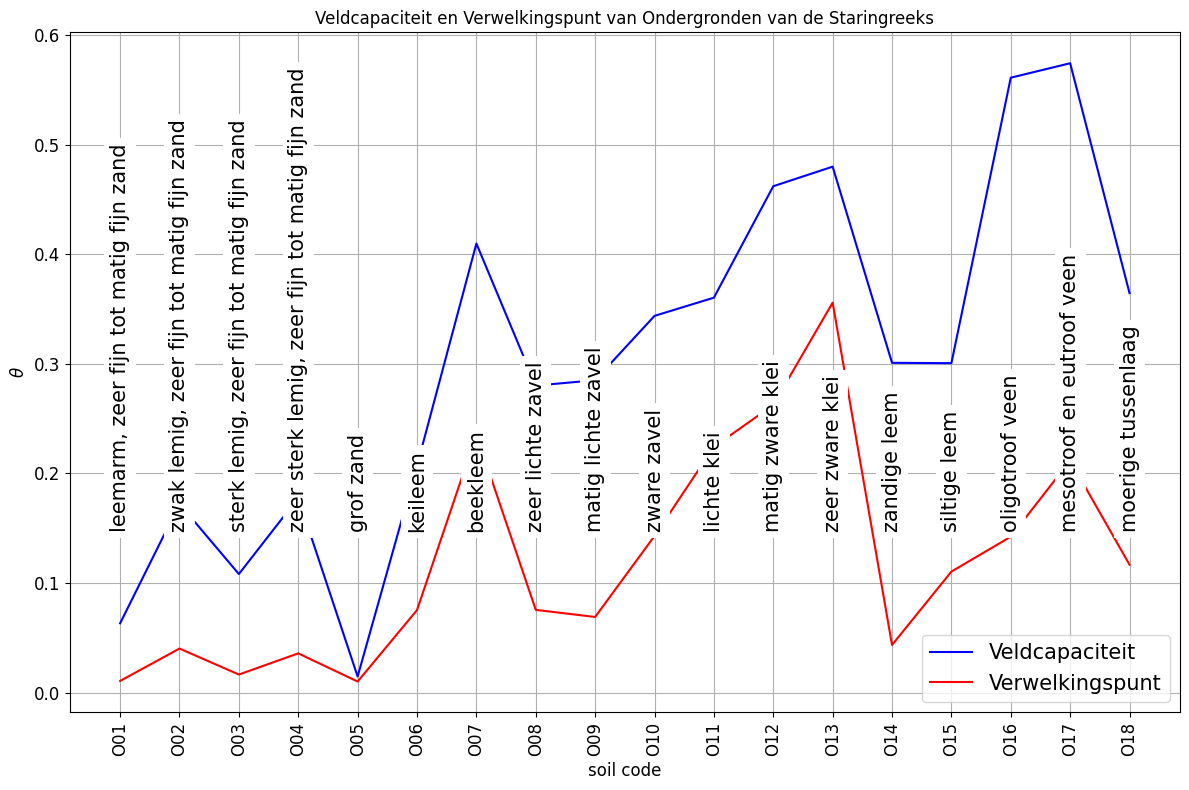

In [11]:
# %% Show field capacities and wilting points
for BO in ['Boverngronden', 'Ondergronden']:
    title = f'Veldcapaciteit en Verwelkingspunt van {BO} van de Staringreeks'
    xlabel = 'soil code'
    ylabel = r'$\theta$'
    ax = etc.newfig(title, xlabel, ylabel)

    fcs, wps, codes = [], [], []
    for code in [c for c in ds.Soil.data.index if c.startswith(BO[0])]:
        soil = ds.Soil(code)
        codes.append(code)
        fcs.append(soil.theta_fc())
        wps.append(soil.theta_wp())
        
        i = int(code[1:])
        ax.text(int(code[1:]) - 1, 0.15,
                soil.props['Omschrijving'], ha='center', rotation=90, fontsize=15, zorder=5,
                bbox=dict(facecolor='white',
                        alpha=1,
                        edgecolor='none'))

    ax.plot(codes, np.array(fcs), 'b', label='Veldcapaciteit')
    ax.plot(codes, np.array(wps), 'r', label='Verwelkingspunt')
    ax.legend(fontsize=15, loc='lower right')

    #ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.xticks(rotation=90, ha="center")
    plt.tight_layout()

### Hydraulic conductivity at field capacity

The hydraulic conductivity ad field capacity is conceptually considered zero. To see to what extent this is approximately correct, we here show the conductivity for each of the Dutch soils at their field capacity.

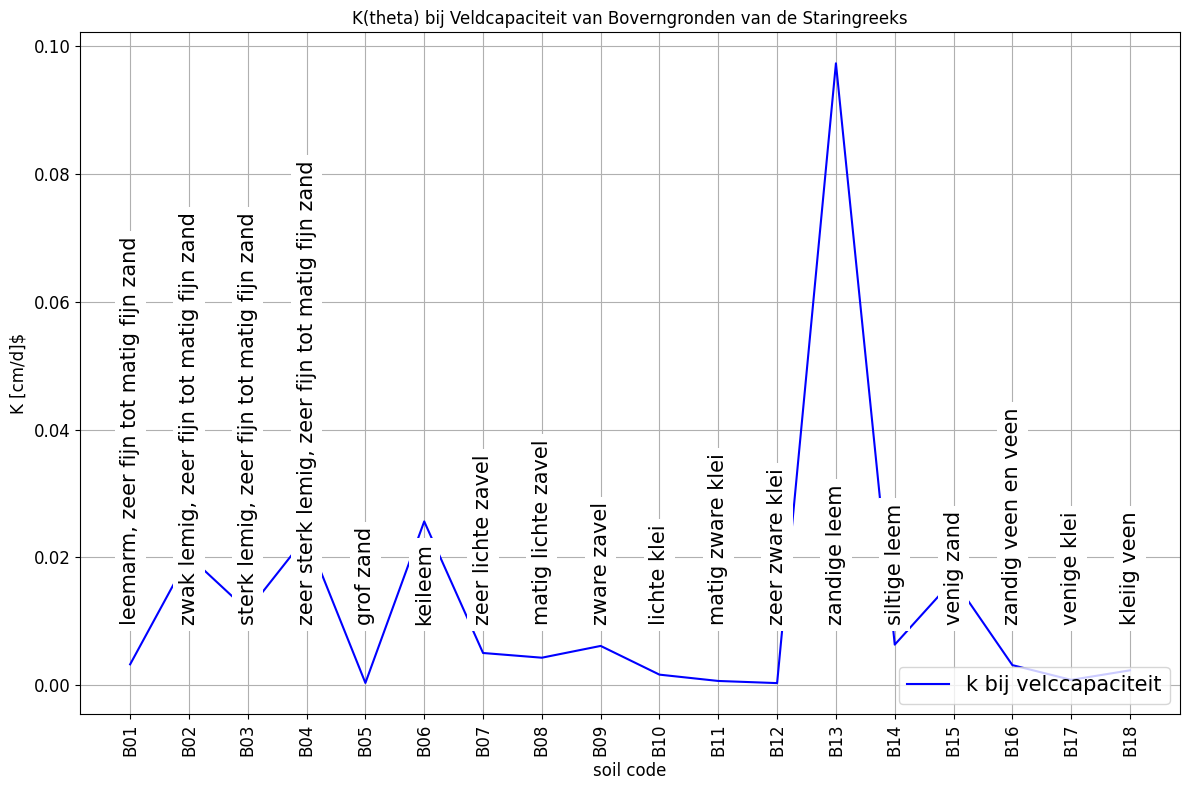

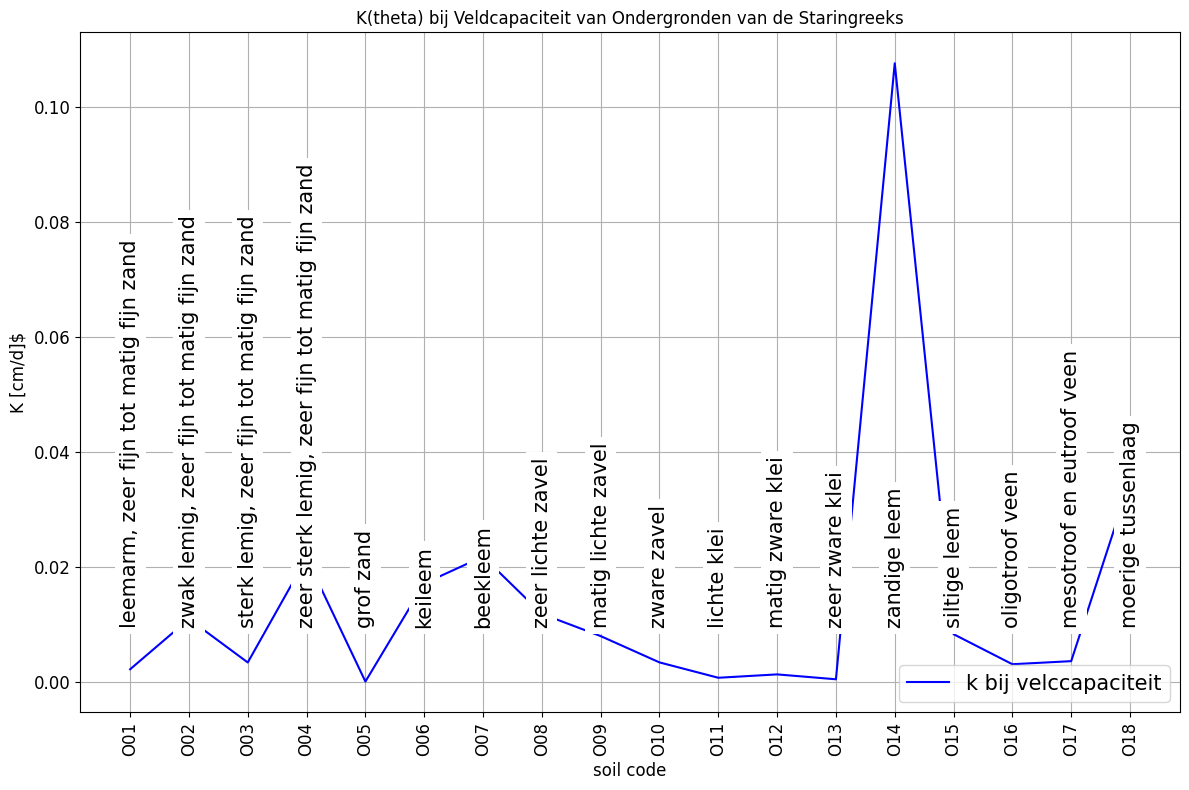

In [12]:
# %% K(theta) bij veldcapaciteit (pF=2.5)
for BO in ['Boverngronden', 'Ondergronden']:
    title = f'K(theta) bij Veldcapaciteit van {BO} van de Staringreeks'
    xlabel = 'soil code'
    ylabel = 'K [cm/d]$'
    ax = etc.newfig(title, xlabel, ylabel)

    fcs, wps, kvalues, codes = [], [], [], []
    for code in [c for c in ds.Soil.data.index if c.startswith(BO[0])]:
        soil = ds.Soil(code)
        codes.append(code)
        K = soil.K(soil.theta_fc(pF=2.5))
        kvalues.append(K)
        
        i = int(code[1:])
        ax.text(int(code[1:]) - 1, 0.01,
                soil.props['Omschrijving'], ha='center', rotation=90, fontsize=15, zorder=5,
                bbox=dict(facecolor='white',
                        alpha=1,
                        edgecolor='none'))

    ax.plot(codes, np.array(kvalues), 'b', label='k bij velccapaciteit')    
    ax.legend(fontsize=15, loc='lower right')

    #ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.xticks(rotation=90, ha="center")
    plt.tight_layout()

### Throttling the ET when the rootzone it drying out or too wet.
In a root zone model, the evapotranspiration is throttled when the moisture content is lowered beyond some level. It is also throttled when the soil is too wet. There are different ways to model this. Implemented are Feddes' method, A smooth method that is continuous and almost equivalent to Feddes. There is Mualem which is purely based on the hydraulic conductivity and declines much faster than Feddes. And there is a blend method that mixes Feddes and Mualem. They are all shown below.

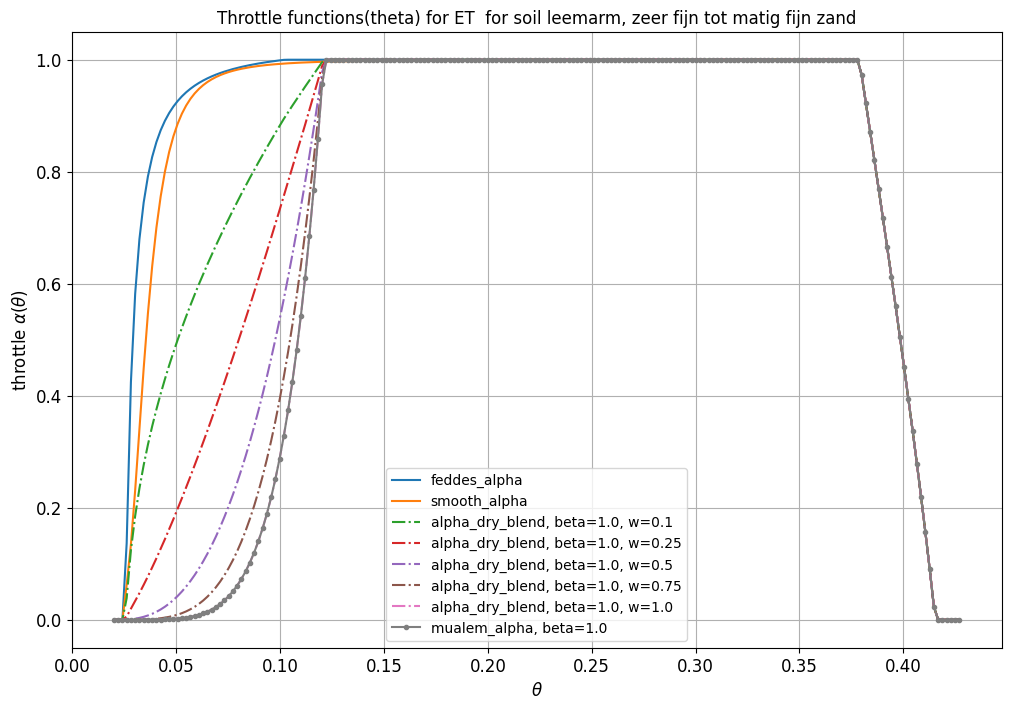

In [13]:
# %% Show the throttle function to throttle ET depending on theta
soil = sand_o

title = f"Throttle functions(theta) for ET  for soil {soil.props['Omschrijving']}"
ax = etc.newfig(title, r"$\theta$", r"throttle $\alpha(\theta)$")

theta = np.linspace(soil.props['theta_r'], soil.props['theta_s'], 200)

# ax.plot(theta, soil.alpha_wet(theta), label=r'alpha_wett')
ax.plot(theta, soil.feddes_alpha(theta), label='feddes_alpha')
ax.plot(theta, soil.smooth_alpha(theta), label='smooth_alpha')
beta = 1.0
for w in [0.1, 0.25, 0.5, 0.75, 1.0]:
    ax.plot(theta, soil.alpha_dry_blend(theta, beta=beta, w=w), '-.',
        label=f'alpha_dry_blend, beta={beta}, w={w}')
for beta in [1.0]:
        ax.plot(theta, soil.mualem_alpha(theta, beta=beta), '.-', label=f'mualem_alpha, beta={beta}')
ax.legend()
plt.show()